In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import random, warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
warnings.filterwarnings("ignore")

# Model CNN From scratch

## Set random seeds for reproducibility

In [14]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


##  Load and Explore Dataset

In [3]:
train_csv_path = '/kaggle/input/leaf-wise-mulberry-classification/train.csv'
test_csv_path = '/kaggle/input/leaf-wise-mulberry-classification/test (1).csv'

train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)

In [4]:
print("Train columns:", train_data.columns)
print("Test columns:", test_data.columns)
print("Number of train samples:", len(train_data))
print("Number of test samples:", len(test_data))

Train columns: Index(['path', 'label'], dtype='object')
Test columns: Index(['path'], dtype='object')
Number of train samples: 3719
Number of test samples: 1543


In [5]:
display(train_data.head())
display(test_data.head())

,path,label
0,/kaggle/input/leaf-wise-mulberry-classificatio...,ChiangMai60
1,/kaggle/input/leaf-wise-mulberry-classificatio...,ChiangMai60
2,/kaggle/input/leaf-wise-mulberry-classificatio...,ChiangMai60
3,/kaggle/input/leaf-wise-mulberry-classificatio...,ChiangMai60
4,/kaggle/input/leaf-wise-mulberry-classificatio...,ChiangMai60


,path
0,/kaggle/input/leaf-wise-mulberry-classificatio...
1,/kaggle/input/leaf-wise-mulberry-classificatio...
2,/kaggle/input/leaf-wise-mulberry-classificatio...
3,/kaggle/input/leaf-wise-mulberry-classificatio...
4,/kaggle/input/leaf-wise-mulberry-classificatio...


## Visualize Sample Images from Each Class

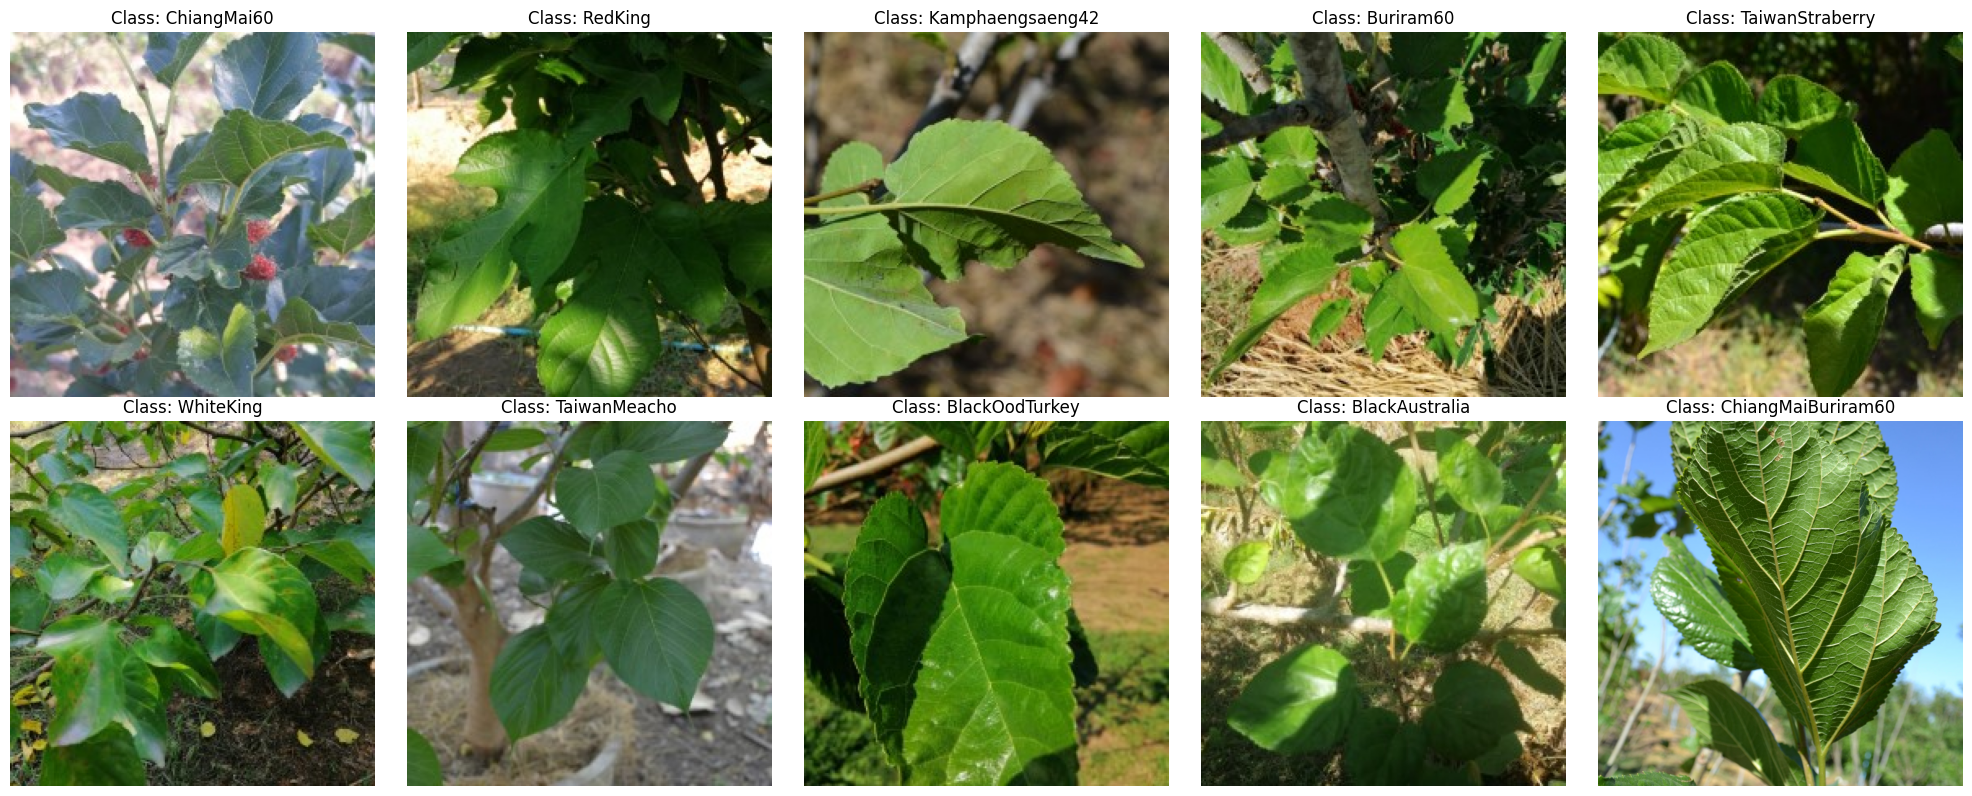

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

classes = train_data['label'].unique()

for i, cls in enumerate(classes):
    sample_file = train_data[train_data['label'] == cls].sample(n=1)['path'].values[0]
    img = Image.open(sample_file)
    axes[i].imshow(img)
    axes[i].set_title(f'Class: {cls}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## Data Preprocessing 

In [7]:
def preprocess_images(image_paths, img_size=(224, 224), channels=3):
    images = []
    for path in image_paths:
        if isinstance(path, (list, np.ndarray)) and len(path) == 1:
            path = path[0]
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=channels)
        image = tf.image.resize(image, img_size) / 255.0  
        images.append(image.numpy())
    return np.array(images)


## Split Dataset & Preprocess Images

In [8]:
images_paths = train_data['path'].values
labels = train_data['label'].values

x_train_paths, x_val_paths, y_train, y_val = train_test_split(images_paths, labels, test_size=0.2, random_state=42)

x_test_paths = test_data['path'].values

## Preprocess images

In [9]:
x_train_images = preprocess_images(x_train_paths)
x_val_images = preprocess_images(x_val_paths)
x_test_images = preprocess_images(x_test_paths)

I0000 00:00:1753103024.365129     112 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Data Augmentation 

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,  
    fill_mode='nearest'
)

train_datagen.fit(x_train_images)

## Label Encoding

In [11]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

## Build CNN Model

In [15]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,602 (1.17 MB)

 Trainable params: 305,706 (1.17 MB)

 Non-trainable params: 896 (3.50 KB)

## Compile Model

In [51]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Callbacks

In [52]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

## Train Model

In [66]:
batch_size = 32
epochs = 50

history = model.fit(
    train_datagen.flow(x_train_images, y_train_encoded, batch_size=batch_size),
    validation_data=(x_val_images, y_val_encoded),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 30s 317ms/step - accuracy: 0.7215 - loss: 0.7789 - val_accuracy: 0.7406 - val_loss: 0.7656 - learning_rate: 1.0000e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 28s 301ms/step - accuracy: 0.7255 - loss: 0.7590 - val_accuracy: 0.7406 - val_loss: 0.7614 - learning_rate: 1.0000e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 29s 311ms/step - accuracy: 0.7490 - loss: 0.7285 - val_accuracy: 0.7809 - val_loss: 0.7099 - learning_rate: 1.0000e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 28s 303ms/step - accuracy: 0.7517 - loss: 0.6984 - val_accuracy: 0.7003 - val_loss: 0.8820 - learning_rate: 1.0000e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 28s 304ms/step - accuracy: 0.7675 - loss: 0.7152 - val_accuracy: 0.7769 - val_loss: 0.6465 - learning_rate: 1.0000e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 28s 304ms/step - accuracy: 0.7642 - loss: 0.6764 - val_accuracy: 0.6546 - val_loss: 1.0339 - learning_rate: 1.0000e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 28s 301ms/step - acc

## Plot Training History

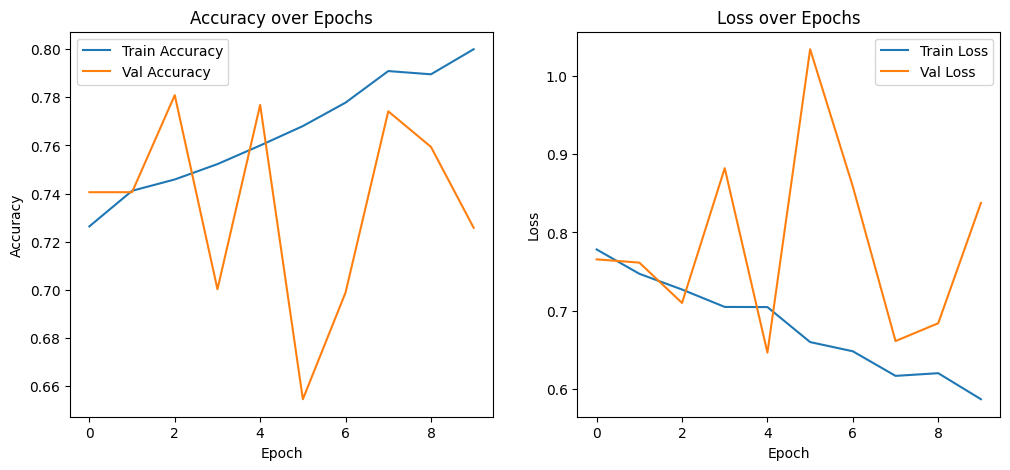

In [67]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Predict on Test Set

In [68]:
predictions = model.predict(x_test_images)
predicted_classes = predictions.argmax(axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)
print(predicted_labels)

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
['TaiwanMeacho' 'TaiwanMeacho' 'Kamphaengsaeng42' ... 'BlackOodTurkey'
 'TaiwanMeacho' 'BlackAustralia']


# ****PreTrained Model****

In [15]:
train_df = pd.read_csv('/kaggle/input/leaf-wise-mulberry-classification/train.csv')
test_df = pd.read_csv('/kaggle/input/leaf-wise-mulberry-classification/test (1).csv')

# Preprocessing

In [16]:
def preprocess_images(paths, size=(300,300)):
    imgs = []
    for p in paths:
        img = tf.io.read_file(p)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, size)
        img = preprocess_input(img)
        imgs.append(img.numpy())
    return np.array(imgs)

# Train & Test Split

In [17]:
X = train_df['path'].values; y = train_df['label'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test = test_df['path'].values

# Preprocessing Image

In [18]:
# Preprocess
X_train = preprocess_images(X_train, size=(300,300))
X_val = preprocess_images(X_val, size=(300,300))
X_test = preprocess_images(X_test, size=(300,300))

# Label Encoder

In [19]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_train_cat = tf.keras.utils.to_categorical(y_train_enc)
y_val_cat = tf.keras.utils.to_categorical(y_val_enc)
num_classes = y_train_cat.shape[1]

# Data Augmentation

In [20]:
datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, zoom_range=0.3,
    horizontal_flip=True, vertical_flip=True
)
datagen.fit(X_train)

# Mix Up Function

In [21]:
def mixup(batch_x, batch_y, alpha=0.2):
    # Sample lambda value from the Beta distribution for mixing strength
    lam = np.random.beta(alpha, alpha)
    
    # Create a random permutation of the batch indices
    idx = np.random.permutation(len(batch_x))
    
    # Mix the input images using the lambda value
    x = lam * batch_x + (1 - lam) * batch_x[idx]
    
    # Mix the labels in the same way
    y = lam * batch_y + (1 - lam) * batch_y[idx]
    
    return x, y  # Return the mixed inputs and labels


# PreTrained Model

In [22]:
base = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300,300,3))
base.trainable = False
inp = Input(shape=(300,300,3))
x = base(inp, training=False)
x = GlobalAveragePooling2D()(x)
out = Dense(num_classes, activation='softmax')(x)
model = Model(inp, out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        15,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,798,905 (41.19 MB)

 Trainable params: 15,370 (60.04 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [23]:
# Define a cosine annealing learning rate schedule
def cosine_anneal(epoch, lr):
    total = 40  # Total number of epochs assumed
    return 1e-3 * (np.cos(np.pi * epoch / total) + 1) / 2  # Adjust learning rate using cosine curve

# Set up training callbacks
callbacks = [
    # Stop training early if validation accuracy doesn't improve for 5 epochs
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    
    # Reduce learning rate if validation accuracy plateaus for 3 epochs
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6),
    
    # Apply cosine annealing schedule to adjust learning rate over epochs
    LearningRateScheduler(cosine_anneal)
]


# Train Model

In [24]:
batch_size = 32
epochs = 18
history_head = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=batch_size),
    validation_data=(X_val, y_val_cat),
    epochs=epochs
)

Epoch 1/18
93/93 ━━━━━━━━━━━━━━━━━━━━ 119s 890ms/step - accuracy: 0.3447 - loss: 1.9257 - val_accuracy: 0.6613 - val_loss: 1.1097
Epoch 2/18
93/93 ━━━━━━━━━━━━━━━━━━━━ 55s 588ms/step - accuracy: 0.6736 - loss: 1.1194 - val_accuracy: 0.7903 - val_loss: 0.7960
Epoch 3/18
93/93 ━━━━━━━━━━━━━━━━━━━━ 54s 582ms/step - accuracy: 0.7423 - loss: 0.8784 - val_accuracy: 0.8293 - val_loss: 0.6672
Epoch 4/18
93/93 ━━━━━━━━━━━━━━━━━━━━ 55s 595ms/step - accuracy: 0.7725 - loss: 0.7594 - val_accuracy: 0.8306 - val_loss: 0.6103
Epoch 5/18
93/93 ━━━━━━━━━━━━━━━━━━━━ 54s 585ms/step - accuracy: 0.7938 - loss: 0.6896 - val_accuracy: 0.8495 - val_loss: 0.5341
Epoch 6/18
93/93 ━━━━━━━━━━━━━━━━━━━━ 55s 593ms/step - accuracy: 0.8171 - loss: 0.6272 - val_accuracy: 0.8589 - val_loss: 0.4961
Epoch 7/18
93/93 ━━━━━━━━━━━━━━━━━━━━ 55s 588ms/step - accuracy: 0.8183 - loss: 0.6056 - val_accuracy: 0.8468 - val_loss: 0.4956
Epoch 8/18
93/93 ━━━━━━━━━━━━━━━━━━━━ 54s 580ms/step - accuracy: 0.8361 - loss: 0.5771 - val_acc

# Fine Tune

In [25]:
base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])


In [26]:
history_ft = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    validation_data=(X_val, y_val_cat),
    epochs=30, initial_epoch=history_head.epoch[-1], 
    callbacks=callbacks
)

Epoch 18/30


E0000 00:00:1753250676.333555      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753250676.551640      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753250677.204733      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753250677.467715      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


31/93 ━━━━━━━━━━━━━━━━━━━━ 33s 542ms/step - accuracy: 0.7191 - loss: 0.8066

E0000 00:00:1753250710.972712      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753250711.191680      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753250711.833687      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753250712.097955      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


93/93 ━━━━━━━━━━━━━━━━━━━━ 132s 926ms/step - accuracy: 0.7861 - loss: 0.6312 - val_accuracy: 0.9220 - val_loss: 0.2350 - learning_rate: 6.1672e-04
Epoch 19/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 54s 577ms/step - accuracy: 0.9183 - loss: 0.2460 - val_accuracy: 0.9583 - val_loss: 0.1330 - learning_rate: 5.7822e-04
Epoch 20/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 54s 581ms/step - accuracy: 0.9307 - loss: 0.1874 - val_accuracy: 0.9341 - val_loss: 0.1666 - learning_rate: 5.3923e-04
Epoch 21/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 55s 589ms/step - accuracy: 0.9589 - loss: 0.1428 - val_accuracy: 0.9476 - val_loss: 0.1373 - learning_rate: 5.0000e-04
Epoch 22/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 54s 583ms/step - accuracy: 0.9673 - loss: 0.1015 - val_accuracy: 0.9610 - val_loss: 0.1094 - learning_rate: 4.6077e-04
Epoch 23/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 54s 580ms/step - accuracy: 0.9736 - loss: 0.0860 - val_accuracy: 0.9516 - val_loss: 0.1254 - learning_rate: 4.2178e-04
Epoch 24/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 53s 573ms/step - accurac

# Plot Training Curves

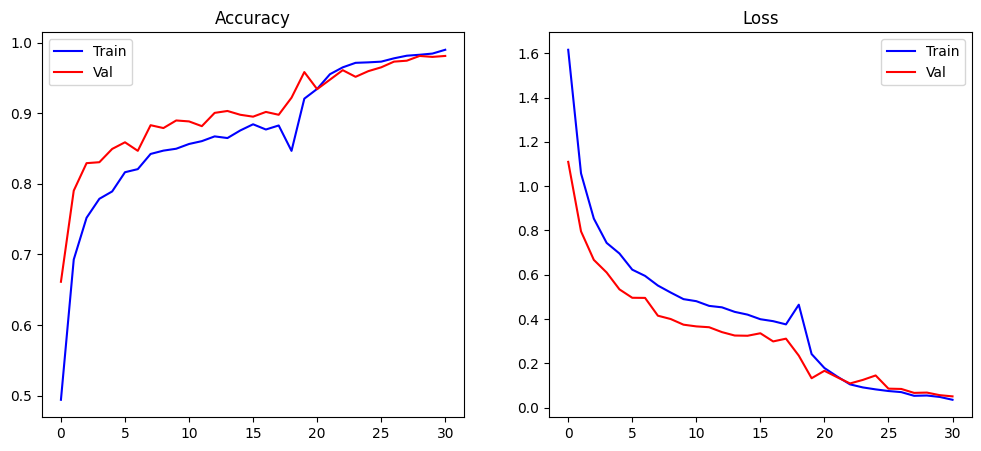

In [27]:
acc = history_head.history['accuracy'] + history_ft.history['accuracy']
val_acc = history_head.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history_head.history['loss'] + history_ft.history['loss']
val_loss = history_head.history['val_loss'] + history_ft.history['val_loss']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(acc,'b',label='Train'); plt.plot(val_acc,'r',label='Val'); plt.legend()
plt.title('Accuracy'); plt.subplot(1,2,2)
plt.plot(loss,'b',label='Train'); plt.plot(val_loss,'r',label='Val'); plt.legend()
plt.title('Loss'); plt.show()

# Confusion Matrix

24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 482ms/step


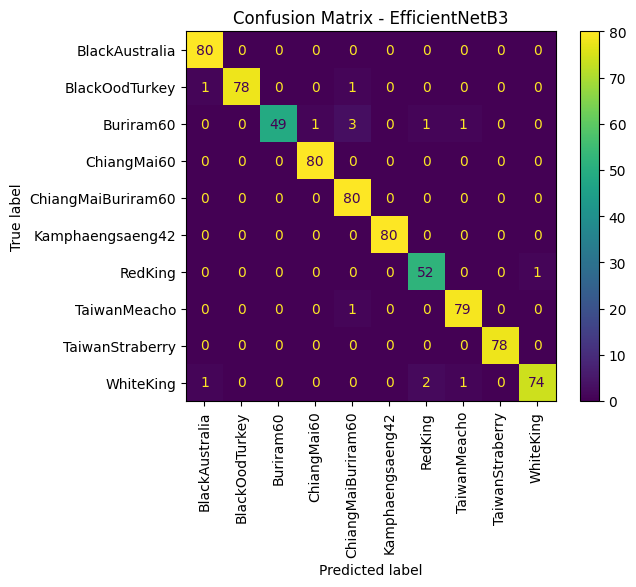

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_val_pred = np.argmax(model.predict(X_val), axis=1)
ConfusionMatrixDisplay.from_predictions(y_val_enc, y_val_pred, display_labels=le.classes_, xticks_rotation='vertical')
plt.title("Confusion Matrix - EfficientNetB3")
plt.show()

## Test model

In [29]:
pred = model.predict(X_test)
pred_labels = le.inverse_transform(np.argmax(pred, axis=1))

49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step


## Save csv file

In [30]:
pd.DataFrame({'path': test_df['path'], 'label': pred_labels}).to_csv('submission_test88.csv', index=False)